In [1]:
# Carga de contexto y librerias para el notebook :D
%load_ext kedro.ipython
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

The kedro.ipython extension is already loaded. To reload it, use:
  %reload_ext kedro.ipython


In [4]:
df = catalog.load("Features_training_v2")   # lee el dataset del catálogo
list(df.columns)  

[10/25/25 02:43:05] INFO     Loading data from Features_training_v2 (ParquetDataset)...        ]8;id=820412;file://C:\Users\AlexandreKz\Documents\GitHub\Ml_Bank\venv\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=811083;file://C:\Users\AlexandreKz\Documents\GitHub\Ml_Bank\venv\Lib\site-packages\kedro\io\data_catalog.py#1046\1046]8;;\

['Monetary', 'TimeSinceLastTxn', 'IsLateNight', 'AmountZScoreByLocation', 'IsWeekend']

In [5]:
# =========================================================
# ⚙️ REGRESIÓN LINEAL MÚLTIPLE – FEATURES_TRAINING_V1
# =========================================================
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# =========================================================
# 1️⃣ Variables dependiente e independientes
# =========================================================
X = df[["AmountZScoreByLocation", "TimeSinceLastTxn", "IsLateNight", "IsWeekend"]]
y = df["Monetary"]

# =========================================================
# 2️⃣ Train/Test Split
# =========================================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# =========================================================
# 3️⃣ Escalamiento
# =========================================================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# =========================================================
# 4️⃣ Modelo + Cross Validation
# =========================================================
model = LinearRegression()
cv = KFold(n_splits=5, shuffle=True, random_state=42)

cv_r2 = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring="r2")
cv_rmse = np.sqrt(-cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring="neg_mean_squared_error"))

print("=== Cross Validation Results (5-Fold) ===")
print("R² promedio:", round(cv_r2.mean(), 4))
print("R² desviación:", round(cv_r2.std(), 4))
print("RMSE promedio:", round(cv_rmse.mean(), 2))

# =========================================================
# 5️⃣ Entrenar y evaluar en test
# =========================================================
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

results = {
    "model_name": "LinearRegression",
    "r2_mean_cv": round(cv_r2.mean(), 4),
    "r2_std_cv": round(cv_r2.std(), 4),
    "r2_test": round(r2, 4),
    "rmse": round(rmse, 2),
    "mae": round(mae, 2)
}

print("\n=== Resultados en Test ===")
print(results)

# =========================================================
# 6️⃣ Coeficientes
# =========================================================
coef_df = pd.DataFrame({
    "Variable": X.columns,
    "Coeficiente": model.coef_.round(4)
})
print("\n=== Coeficientes del modelo ===")
display(coef_df)

=== Cross Validation Results (5-Fold) ===
R² promedio: 0.7007
R² desviación: 0.0019
RMSE promedio: 503.24

=== Resultados en Test ===
{'model_name': 'LinearRegression', 'r2_mean_cv': np.float64(0.7007), 'r2_std_cv': np.float64(0.0019), 'r2_test': 0.704, 'rmse': np.float64(500.32), 'mae': 304.02}

=== Coeficientes del modelo ===


,Variable,Coeficiente
0,AmountZScoreByLocation,752.0960
1,TimeSinceLastTxn,166.9973
2,IsLateNight,1.0308
3,IsWeekend,2.2691


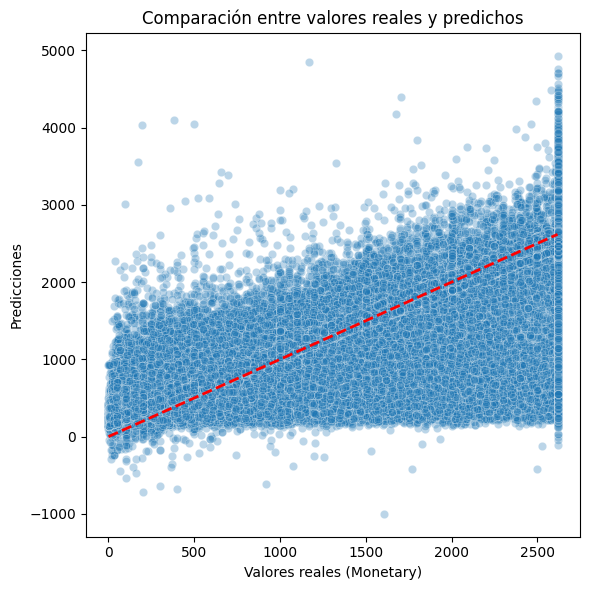

In [7]:

plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Valores reales (Monetary)")
plt.ylabel("Predicciones")
plt.title("Comparación entre valores reales y predichos")
plt.tight_layout()
plt.show()

# Métrica	Valor	Interpretación
# R² (cross-val promedio)	0.7007	El modelo explica el 70% de la variabilidad del gasto total (Monetary) en validación cruzada. Altísimo para un modelo tan simple.
# R² (test)	0.704	Consistente con la validación → modelo estable, sin sobreajuste.
# RMSE	≈ 500	Error cuadrático medio de 500 unidades monetarias → en promedio, el modelo se equivoca ±500 respecto al gasto real.
# MAE	≈ 304	Error absoluto medio más conservador → la diferencia típica entre predicción y valor real.

# ✅ Conclusión:
# Tu modelo lineal está muy bien ajustado y generaliza correctamente. No está sobreentrenado (CV y test casi iguales).

# modelo aprende la tendencia principal muy bien.

# Tiene ligera pérdida de precisión en los extremos altos.

# Para mejorarlo, podés probar:

# 🔹 Ridge o Lasso (regularización).

# 🔹 Transformar Monetary con np.log1p().

# 🔹 Incluir variables de comportamiento más dinámicas (como txn_per_day o avg_balance si están limpias).